In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import sys
PATH_TO_REPO = "/home/bis/2021_SJH_detectability/Detectability/2021ACS_DeepDigest/"
sys.path.append(PATH_TO_REPO)
import read_protein_sequences
import cut_and_gene_tradata
import predictor
import sys
import getopt

In [2]:
train = pd.read_csv('data_CS/train.csv')
test = pd.read_csv('data_CS/test.csv')
df_data_CS = pd.concat([train, test], axis=0).reset_index(drop=True)

train = pd.read_csv('data/train_diff_hpp.csv')
test = pd.read_csv('data/test_diff_hpp.csv')
df_data = pd.concat([train, test], axis=0).reset_index(drop=True)

new_col = lambda x: x[8:-8]
df_data_CS['nterm_30'] = df_data_CS['nterm'].values
df_data_CS['cterm_30'] = df_data_CS['cterm'].values
df_data_CS['miss1_30'] = df_data_CS['miss1'].values
df_data_CS['miss2_30'] = df_data_CS['miss2'].values

df_data_CS['nterm'] = df_data_CS.nterm_30.apply(new_col).values
df_data_CS['cterm'] = df_data_CS.cterm_30.apply(new_col).values
df_data_CS['miss1'] = df_data_CS.miss1_30.apply(new_col).values
df_data_CS['miss2'] = df_data_CS.miss2_30.apply(new_col).values

df = df_data_CS.merge(df_data, on=['peptide', 'nterm', 'cterm', 'miss1', 'miss2', 'label'], how='inner')
df = df.loc[df.label==True]

print(df.shape, len(df.peptide.unique()))

(413625, 10) 407647


In [3]:
df.to_csv('data/df_positive.csv', index=False)

In [4]:
p = {ts for row in df[['nterm_30', 'cterm_30']].values for ts in row}
n = {ts for row in df[['miss1_30', 'miss2_30']].values for ts in row}
multi = p.intersection(n)
p = p.difference(multi)
n = n.difference(multi)
print(len(p), len(n), len(multi))

df_p = pd.DataFrame([[ts, 'True'] for ts in p], columns=['cleavage_site', 'label'])
df_n = pd.DataFrame([[ts, 'False'] for ts in n], columns=['cleavage_site', 'label'])
df_m = pd.DataFrame([[ts, 'Multi'] for ts in multi], columns=['cleavage_site', 'label'])
df_deepdigest = pd.concat([df_p, df_n, df_m], axis=0).reset_index(drop=True)

312822 37945 167251


# Deep Digest

In [5]:
from tensorflow.keras.models import model_from_json

print("Loading model...")
protease='Trypsin'
# load architecture
json_file = open(PATH_TO_REPO+'%s.json'%protease, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load parameters
loaded_model.load_weights(PATH_TO_REPO+'%s.h5'%protease)

Loading model...


In [6]:
print(loaded_model.summary())
loaded_model.pop()
loaded_model.pop()
print(loaded_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 31, 21)            441       
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 21)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 30, 21)            903       
_________________________________________________________________
average_pooling1d_1 (Average (None, 29, 21)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 28, 21)            903       
_________________________________________________________________
average_pooling1d_2 (Average (None, 27, 21)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 21)               

In [ ]:
mers = np.array(predictor.coding(df_deepdigest.cleavage_site.values))
vectors = loaded_model.predict(mers)
vectors_deepdigest = TSNE(n_components=2).fit_transform(vectors)

In [ ]:
label_deepdigest = {idx: lab for idx, lab in zip(df_deepdigest.index, df_deepdigest.label.values)}

In [ ]:
clv = vectors_deepdigest[:len(df_p)]
mclv = vectors_deepdigest[len(df_p):len(df_p)+len(df_n)]
multiclv = vectors_deepdigest[len(df_p)+len(df_n):]

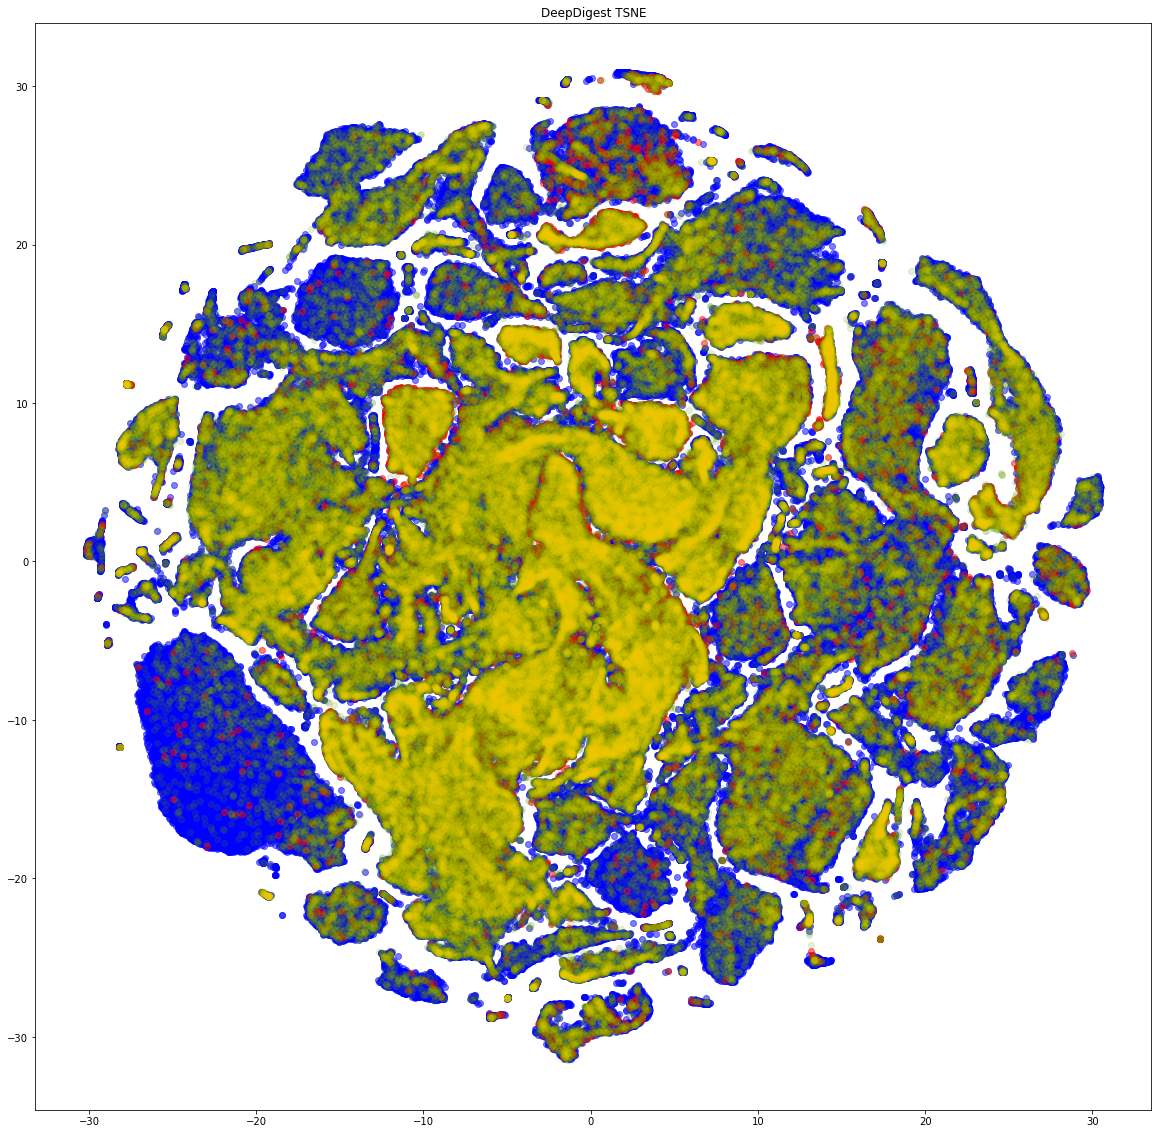

In [50]:
plt.figure(figsize=(20,20))

plt.scatter(clv[:, 0], clv[:, 1], color='blue', alpha=0.5, label='Cleavaged')
plt.scatter(mclv[:, 0], mclv[:, 1], color='red', alpha=0.5, label='MissedCleavaged')
plt.scatter(multiclv[:, 0], multiclv[:, 1], color='green', alpha=0.1, label='Multi-Label-Cleavaged')
plt.scatter(multiclv[:, 0], multiclv[:, 1], color='gold', alpha=0.05, label='Multi-Label-MissedCleavaged')

plt.title('DeepDigest TSNE')
plt.savefig('log/result_TSNE_DeepDigest.png', )
plt.show()

* sampling

In [51]:
cnt = min(len(clv), len(mclv), len(multiclv))

clv_sample = clv[:cnt]
mclv_sample = mclv[:cnt]
multiclv_sample = multiclv[:cnt]

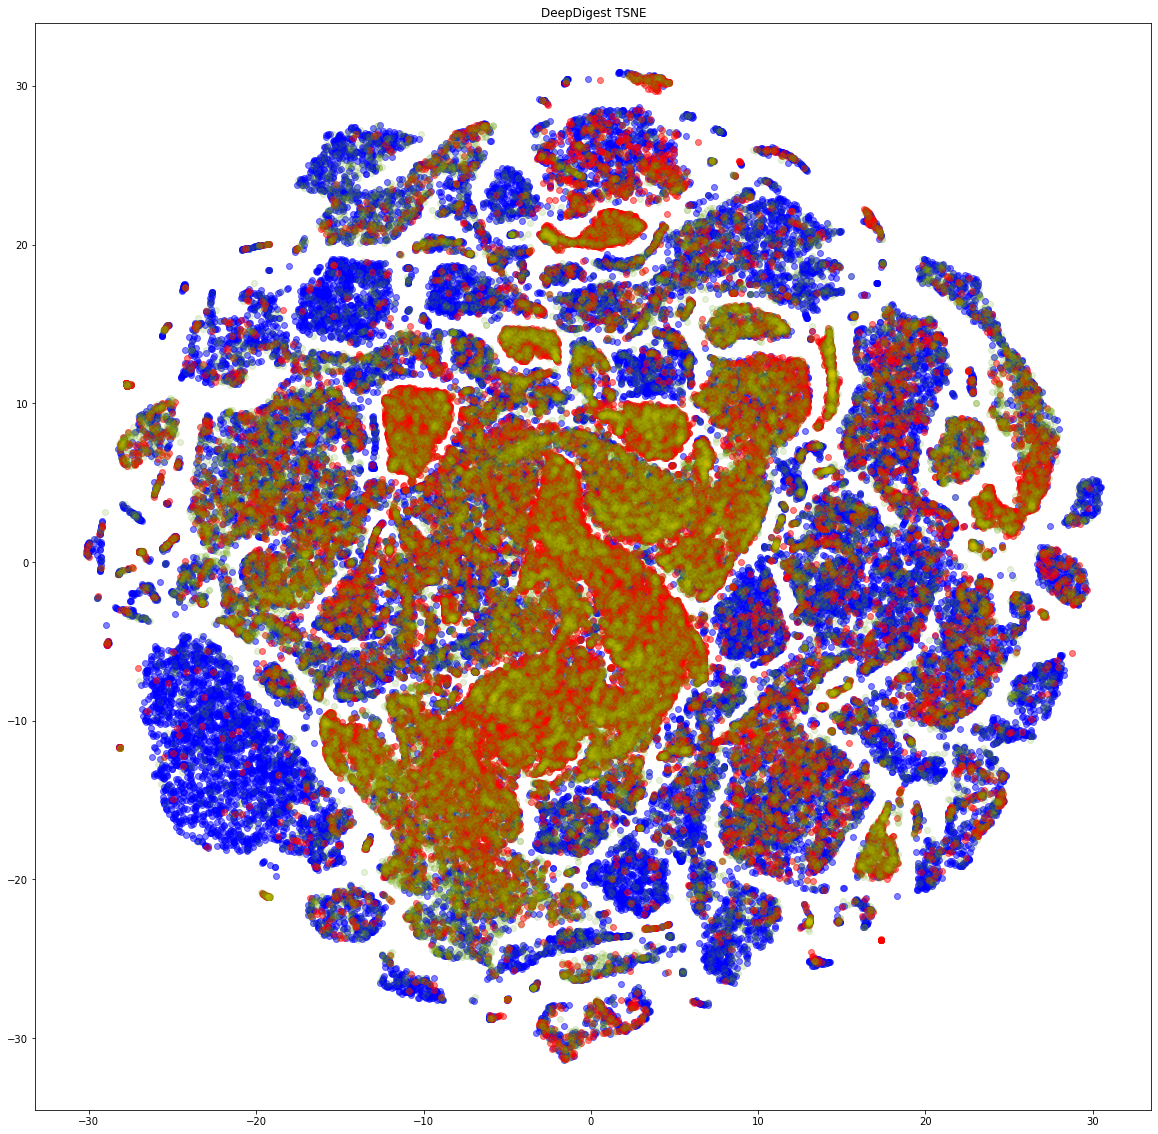

In [58]:
plt.figure(figsize=(20,20))

plt.scatter(clv_sample[:, 0], clv_sample[:, 1], color='blue', alpha=0.5, label='Cleavaged')
plt.scatter(mclv_sample[:, 0], mclv_sample[:, 1], color='red', alpha=0.5, label='MissedCleavaged')
plt.scatter(multiclv_sample[:, 0], multiclv_sample[:, 1], color='green', alpha=0.1, label='Multi-Label-Cleavaged')
plt.scatter(multiclv_sample[:, 0], multiclv_sample[:, 1], color='gold', alpha=0.05, label='Multi-Label-MissedCleavaged')

plt.title('DeepDigest TSNE')
plt.savefig('log/result_TSNE_DeepDigest.png', )
plt.show()